In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline


import datetime as dt 
import seaborn as sns

In [2]:
df = pd.read_csv("../archive/ks-projects-201801.csv")
display(df.head())


# ・ID：クラウドファンディングの個別ID
# ・name：クラウドファンディングの名前
# ・category：詳細なカテゴリー
# ・main_category：大まかなカテゴリー
# ・currency ：使用された通貨
# ・deadline：締め切り日時
# ・goal：目標調達資金額
# ・launched：開始した日時
# ・pledged：集まった資金
# ・state：プロジェクトの状態(成功、失敗、キャンセルなど)
# ・backer：集まった支援者
# ・country：プロジェクトが開かれた国
# ・usd pledged： 集まった資金の米ドル換算

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [4]:
df.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [5]:
#37万のデータに対して3000のデータは消しても問題ないと考えた(全体の0.8%程度)
#元データとドロップデータを分けた意味はあまりないのでは？
#次回以降要検討
df_dp = df.dropna()
df_dp.isnull().sum()

ID                  0
name                0
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

In [6]:
#開始と締切から日数を計算
#deadlineとlaunchedをobjectからdatetime型に変更
df_dp['deadline'] = pd.to_datetime(df_dp['deadline'], errors = 'coerce')
df_dp['launched'] = pd.to_datetime(df_dp['launched'], errors = 'coerce')

#締切-開始日＝日数(.dt.daysで時間を日数に変更)を新しく挿入
df_dp['period'] = (df_dp['deadline'] - df_dp['launched']).dt.days

display(df_dp.head())

C:\Users\Trick\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Trick\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Trick\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,period
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,29
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,55


In [7]:
#いらないデータを消す
df_dp= df_dp.drop(['ID','deadline','launched','goal','category','country','pledged','backers','usd pledged','usd_pledged_real'], axis=1)
display(df_dp.head())

#ID:意味なし
#deadlin,launched:periodに換算済み
#goal:ドルに直したusd_goal_realを使う
#category:main_categoryとmcategoryはほぼ一致するため。main_categoryを採用
#country:countryとcurrencyはほぼ一致（ユーロ圏のみ異なる）するため。currencyを採用
#それ以降:開始前に知りえる情報のため除外


,name,main_category,currency,state,usd_goal_real,period
0,The Songs of Adelaide & Abullah,Publishing,GBP,failed,1533.95,58
1,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,USD,failed,30000.00,59
2,Where is Hank?,Film & Video,USD,failed,45000.00,44
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,USD,failed,5000.00,29
4,Community Film Project: The Art of Neighborhoo...,Film & Video,USD,canceled,19500.00,55


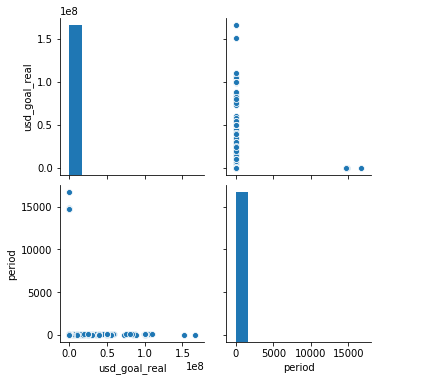

In [8]:
sns.pairplot(df_dp)

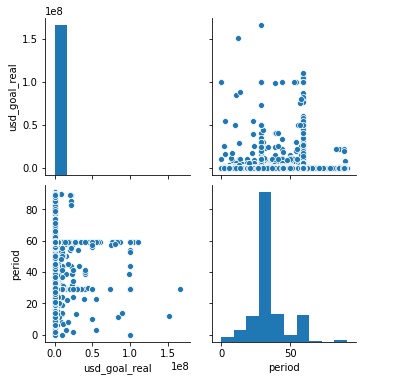

In [9]:
df_dp = df_dp[df_dp['period'] < 10000] # 異常値の除去
sns.pairplot(df_dp)

C:\Users\Trick\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


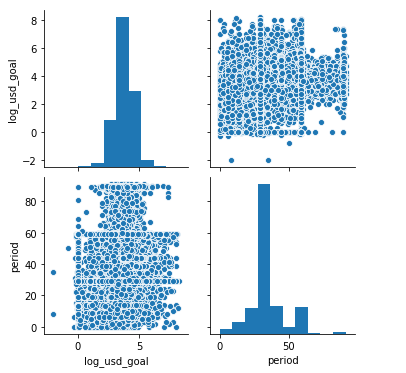

In [10]:
epsilon = 1e-5 # 対数変換の際に負の無限大に発散しないようにフロアリングするパラメータ
df_dp['log_usd_goal'] = df_dp['usd_goal_real'].apply(lambda x: np.log10(x + epsilon))

sns.pairplot(df_dp[['log_usd_goal', 'period']])

In [11]:
#stateを弄る。Day3以前参照
df_dp = df_dp[(df_dp['state'] == 'successful') | (df_dp['state'] == 'failed')]

In [12]:
#successfulをTrueに、failedをFalseに変換
df_dp['state'] = df_dp['state'] =="successful" 
display(df_dp.head())

C:\Users\Trick\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,name,main_category,currency,state,usd_goal_real,period,log_usd_goal
0,The Songs of Adelaide & Abullah,Publishing,GBP,False,1533.95,58,3.185811
1,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,USD,False,30000.00,59,4.477121
2,Where is Hank?,Film & Video,USD,False,45000.00,44,4.653213
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,USD,False,5000.00,29,3.698970
5,Monarch Espresso Bar,Food,USD,True,50000.00,34,4.698970


In [13]:
#nameから単語数を抽出
df_dp['n_words'] = df_dp['name'].apply(lambda x: len(str(x).split(' ')))

C:\Users\Trick\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
display(df_dp.head())

,name,main_category,currency,state,usd_goal_real,period,log_usd_goal,n_words
0,The Songs of Adelaide & Abullah,Publishing,GBP,False,1533.95,58,3.185811,6
1,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,USD,False,30000.00,59,4.477121,8
2,Where is Hank?,Film & Video,USD,False,45000.00,44,4.653213,3
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,USD,False,5000.00,29,3.698970,7
5,Monarch Espresso Bar,Food,USD,True,50000.00,34,4.698970,3


In [15]:
df_dp = df_dp.drop(columns=['name', 'usd_goal_real'])
display(df_dp.head())

,main_category,currency,state,period,log_usd_goal,n_words
0,Publishing,GBP,False,58,3.185811,6
1,Film & Video,USD,False,59,4.477121,8
2,Film & Video,USD,False,44,4.653213,3
3,Music,USD,False,29,3.698970,7
5,Food,USD,True,34,4.698970,3


In [16]:
#Currencyとmain_categoryをワンホットベクトルに変換
df_dp = pd.get_dummies(df_dp, drop_first=True)
display(df_dp.head())

,state,period,log_usd_goal,n_words,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,False,58,3.185811,6,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,False,59,4.477121,8,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,False,44,4.653213,3,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,False,29,3.698970,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,True,34,4.698970,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [17]:
df_dp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331462 entries, 0 to 378660
Data columns (total 31 columns):
state                         331462 non-null bool
period                        331462 non-null int64
log_usd_goal                  331462 non-null float64
n_words                       331462 non-null int64
main_category_Comics          331462 non-null uint8
main_category_Crafts          331462 non-null uint8
main_category_Dance           331462 non-null uint8
main_category_Design          331462 non-null uint8
main_category_Fashion         331462 non-null uint8
main_category_Film & Video    331462 non-null uint8
main_category_Food            331462 non-null uint8
main_category_Games           331462 non-null uint8
main_category_Journalism      331462 non-null uint8
main_category_Music           331462 non-null uint8
main_category_Photography     331462 non-null uint8
main_category_Publishing      331462 non-null uint8
main_category_Technology      331462 non-null uint8
main

In [18]:
#K最近傍法

from sklearn.neighbors import KNeighborsClassifier

X = df_dp.drop('state', axis=1).values
y = df_dp["state"].values

# 全データのうち、何%をテストデータにするか
test_size = 0.2

# ホールドアウト法を実行（テストデータはランダム選択）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

knn = KNeighborsClassifier(n_neighbors=6) # インスタンス生成。n_neighbors:Kの数
knn.fit(X_train, y_train)                 # モデル作成実行
Y_pred = knn.predict(X_test)              # 予測実行

# 精度確認用のライブラリインポートと実行
from sklearn import metrics
metrics.accuracy_score(y_test, Y_pred)    # 予測精度計測

0.6354215377189145

In [19]:
#Day3と同程度の性能を得られた

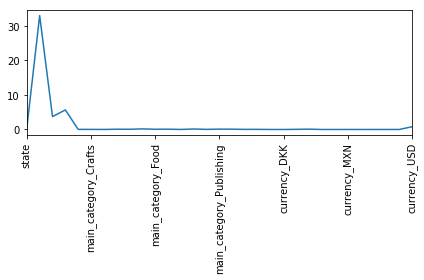

In [20]:
df_dp.mean().plot()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



In [21]:
from sklearn.decomposition import PCA #主成分分析用ライブラリ

df_dp1 = df_dp.drop('state', axis=1)

#標準化
stdsc = StandardScaler()
X = stdsc.fit_transform(df_dp1)

#主成分分析用のオブジェクトをつくる。削減後の次元数を引数で指定する。
pca = PCA(n_components=5) 


pca.fit(df_dp1) #主成分分析の実行

C:\Users\Trick\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Trick\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [22]:
pca.components_

array([[ 9.99934642e-01,  1.06408597e-02,  3.22177901e-03,
        -2.07206776e-05, -3.66905514e-04, -7.63228696e-05,
         8.84443231e-05, -4.96052849e-04,  1.11096866e-03,
        -2.42027167e-05, -9.25409456e-04,  2.26440311e-05,
         1.15761126e-03, -8.02733471e-05, -1.50842545e-04,
         6.62652286e-04, -1.23068645e-04, -1.22996432e-05,
         1.65700209e-05, -1.52411558e-05,  2.06042196e-04,
        -1.21085140e-03,  1.17575960e-06, -2.23851470e-06,
         6.68077279e-05,  8.78696994e-06, -6.17849981e-05,
        -1.91111165e-05, -1.53919438e-05,  1.12922908e-03],
       [-3.31732240e-03,  8.10999918e-03,  9.99784436e-01,
        -4.02914903e-04, -1.47703616e-03,  1.22037984e-04,
         5.42118054e-03, -9.87971706e-04, -1.21192162e-02,
        -1.59112339e-03, -4.46171710e-03, -5.35147181e-04,
         9.71113256e-03, -6.93001201e-04,  5.50565261e-03,
         1.11449145e-03,  1.63618307e-03, -1.05458897e-03,
        -1.13050692e-05, -1.37835566e-04, -9.04666537e-

In [23]:
print("寄与率=",pca.explained_variance_ratio_)
print("合計＝", pca.explained_variance_ratio_.sum())

寄与率= [9.44825781e-01 4.53297218e-02 3.02160515e-03 1.27090986e-03
 9.12006460e-04]
合計＝ 0.995360024346142


In [24]:
# データを主成分空間に写像
feature = pca.transform(df_dp1)

In [25]:
# 主成分得点 
test_data = pd.DataFrame(feature, columns=["PC{}".format(x + 1) for x in range(5)])
test_data

,PC1,PC2,PC3,PC4,PC5
0,25.035362,0.258727,0.850103,1.124315,-0.059413
1,26.059083,2.253658,-0.487558,-0.253468,0.825339
2,11.045828,-2.694076,-0.855318,-0.307569,0.737331
3,-3.950411,1.368913,0.067265,-0.342586,-0.430600
4,1.045834,-2.650004,-0.991000,-0.246871,-0.222067
5,-13.951934,3.384684,0.576189,-0.224748,-0.038469
6,11.058086,2.313304,-0.552227,-0.200450,-0.127515
7,-3.965906,-1.642562,0.325276,0.757662,-0.167117
8,-3.955842,-1.627213,-0.348013,-0.362024,-0.498722
9,-3.964823,-2.641413,-0.009435,-0.229281,-0.121241


In [26]:
#K最近傍法を主成分分析後にやってみる
#基本同じ


from sklearn.neighbors import KNeighborsClassifier

X = test_data.values
y = df_dp["state"].values

# 全データのうち、何%をテストデータにするか
test_size = 0.2

# ホールドアウト法を実行（テストデータはランダム選択）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

knn = KNeighborsClassifier(n_neighbors=6) # インスタンス生成。n_neighbors:Kの数
knn.fit(X_train, y_train)                 # モデル作成実行
Y_pred = knn.predict(X_test)              # 予測実行

# 精度確認用のライブラリインポートと実行
from sklearn import metrics
metrics.accuracy_score(y_test, Y_pred)    # 予測精度計測

0.6282714615419426

In [27]:
#次元を5に削減した結果の精度は元の-0.7%
#元の場合1分程度かかってた計算が一瞬に

#参考文献
#https://tkstock.site/2020/11/07/python-%E4%B8%BB%E6%88%90%E5%88%86%E5%88%86%E6%9E%90-pca-%E3%82%AF%E3%83%A9%E3%82%B9%E3%82%BF%E3%83%AA%E3%83%B3%E3%82%B0-%E5%AE%9F%E8%A3%85/

In [28]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

X = test_data.values
y = df_dp["state"].values

# 全データのうち、何%をテストデータにするか
test_size = 0.2

# ホールドアウト法を実行（テストデータはランダム選択）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

params = {"n_neighbors":np.arange(1,100,1)}

knn1 = KNeighborsClassifier() # インスタンス生成

clf = RandomizedSearchCV(knn1, params, cv=2, random_state=1234, n_iter=20)

clf.fit(X_train, y_train)

RandomizedSearchCV(cv=2, error_score='raise-deprecating',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params=None, iid='warn', n_iter=20, n_jobs=None,
          param_distributions={'n_neighbors': array([ 1,  2, ..., 98, 99])},
          pre_dispatch='2*n_jobs', random_state=1234, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [29]:
clf.best_params_

{'n_neighbors': 83}

In [30]:
clf.best_score_

0.6464066312427169

In [31]:
#0.628から0.646まで上昇

In [50]:
import optuna

def objective(trial):
    X = test_data.values
    y = df_dp["state"].values

    # 全データのうち、何%をテストデータにするか
    test_size = 0.2

    # ホールドアウト法を実行（テストデータはランダム選択）
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 
    
    params = trial.suggest_int('params',1,100)
    
    knn2 = KNeighborsClassifier(params) 
    knn2.fit(X_train, y_train)  
    
    preds = knn2.predict(X_test)
    
    return metrics.accuracy_score(y_test, np.rint(preds))
    
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 20)

[I 2021-11-09 16:36:48,836] A new study created in memory with name: no-name-58b900ea-3730-4ddd-98f3-e943de4233b9
[I 2021-11-09 16:36:52,937] Trial 0 finished with value: 0.6341996892582927 and parameters: {'params': 14}. Best is trial 0 with value: 0.6341996892582927.
[I 2021-11-09 16:36:56,661] Trial 1 finished with value: 0.6282714615419426 and parameters: {'params': 6}. Best is trial 0 with value: 0.6341996892582927.
[I 2021-11-09 16:37:03,332] Trial 2 finished with value: 0.647443923189477 and parameters: {'params': 59}. Best is trial 2 with value: 0.647443923189477.
[I 2021-11-09 16:37:07,730] Trial 3 finished with value: 0.6391323367474696 and parameters: {'params': 18}. Best is trial 2 with value: 0.647443923189477.
[I 2021-11-09 16:37:13,730] Trial 4 finished with value: 0.6445175207035434 and parameters: {'params': 42}. Best is trial 2 with value: 0.647443923189477.
[I 2021-11-09 16:37:22,194] Trial 5 finished with value: 0.649178646312582 and parameters: {'params': 87}. Best

In [ ]:
#(83, 0.646)から(99, 0.649)に
#今回は範囲が狭かったので、それを広げればもっと差は大きくなるはず